# A2

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## a)
The Levenberg-Marquardt method combines the Gauß-Newton method with a gradient decent.

## b)
Calculate the jacobian matrix for the three given models

All functions are scalar, so we expect an 1xn matrix
\begin{align}
f_1(t) &= mt+c \\
\frac{\partial f_1}{\partial m} &= t \\
\frac{\partial f_1}{\partial c} &= 1 
\end{align}

\begin{align}
f_2(t) &= a\exp\left( \left(-\frac{t-b}{c}\right)^2\right) \\
\frac{\partial f_2}{\partial a} &= \exp\left( \left(-\frac{t-b}{c}\right)^2\right) \\
\frac{\partial f_2}{\partial b} &= \frac{2a(t-b)}{c^2}\exp\left( \left(-\frac{t-b}{c}\right)^2\right) \\
\frac{\partial f_2}{\partial c} &= \frac{2a(t-b)^2}{c^3}\exp\left( \left(-\frac{t-b}{c}\right)^2\right) \\
\frac{\partial f_2}{\partial d} &= 1
\end{align}

\begin{align}
f_3(t) &= a\exp\left(-\frac{t}{b}\right) + c\sin\left(\frac{t}{d}\right) \\
\frac{\partial f_3}{\partial a} &= \exp\left(-\frac{t}{b}\right) \\
\frac{\partial f_3}{\partial b} &= a\exp\left(-\frac{t}{b}\right) +\frac{t}{b^2}\\
\frac{\partial f_3}{\partial c} &= \sin\left(\frac{t}{d}\right) \\
\frac{\partial f_3}{\partial d} &= -\frac{ct}{d^2} \cos\left(\frac{t}{d}\right)
\end{align}

In [32]:
def f1(t, m, c):
    return m * t + c


def f2(t, a, b, c, d):
    return a * np.exp(-(((b - t) / c) ** 2)) + d


def f3(t, a, b, c, d):
    return a * np.exp(-t / b) + c * np.sin(t / d)


def j1(t, m, c):
    return np.vstack((t, np.ones_like(t))).T


def j2(t, a, b, c, d):
    inner = -(((b - t) / c) ** 2)
    d_inner = 2 * (b - t) / c**2
    exp = np.exp(inner)
    return np.vstack(
        (exp, a * exp * d_inner, a * exp * inner * 2 / c, np.ones_like(t))
    ).T


def j3(t, a, b, c, d):
    exp = np.exp(-t / b)
    sin = np.sin(t / d)
    cos = np.cos(t / d)
    return np.vstack((exp, -a * t / b**2 * exp, sin, -c * t / d**2 * cos)).T

In [67]:
def levenberg_marquardt(
    t, y, func, jacobian, p0, tol=1e-6, max_iter=10000, alpha=1e-3, beta=0.01, eta=10
):
    p = p0
    max_iter_reached = False
    converged = False
    iter = 0
    f_norm = np.inf
    Delta = beta * np.eye(len(p))
    while not max_iter_reached and not converged:
        iter += 1
        jac = jacobian(t, *p)
        res = y - func(t, *p)
        inv = np.linalg.inv(jac.T @ jac + Delta)
        p_new = p + (alpha * inv) @ jac.T @ res
        f_norm_new = np.linalg.norm(y - func(t, *p_new))
        if f_norm_new < f_norm:
            Delta = Delta / eta
            f_norm = f_norm_new
            converged = np.linalg.norm(p_new - p) < tol
            p = p_new
        else:
            Delta = Delta * eta
            converged = False
        max_iter_reached = iter >= max_iter

    return p, converged, iter

In [34]:
# I got an error with the cp437 encoding, so i manually unzipped the files
t1, y1 = np.load("set_1.npy")
t2, y2 = np.load("set_2.npy")
t3, y3 = np.load("set_3.npy")

In [68]:
p1, converged1, iter1 = levenberg_marquardt(t1, y1, f1, j1, [0, 0], alpha=1)
p2, converged2, iter2 = levenberg_marquardt(t2, y2, f2, j2, [1, 0, 1, 0], alpha=1)
p22, converged22, iter22 = levenberg_marquardt(t2, y2, f2, j2, [5, 3, 3, 0], alpha=1)
p3, converged3, iter3 = levenberg_marquardt(t3, y3, f3, j3, [10, 20, 0, 1], alpha=1)

print(f"Set 1: {p1}, converged: {converged1}, iterations: {iter1}")
print(f"Set 2: {p2}, converged: {converged2}, iterations: {iter2}")
print(f"Set 2: {p22}, converged: {converged22}, iterations: {iter22}")
print(f"Set 3: {p3}, converged: {converged3}, iterations: {iter3}")

/tmp/ipykernel_312928/473870005.py:23: RuntimeWarning: overflow encountered in multiply
  Delta = Delta * eta


Set 1: [ 1.17749243 -3.79849829], converged: True, iterations: 6
Set 2: [-0.48298802 -1.60748013 -0.83964291  1.10079381], converged: True, iterations: 25
Set 2: [ 4.75403865  2.85619374  2.86162134 -0.02413034], converged: False, iterations: 10000
Set 3: [ 8.96891641 24.01719106  0.06445963  0.80927517], converged: True, iterations: 136


The `p22` run didn't converge, but is still a close fit the `p2` result.

In [44]:
sciP1, _ = curve_fit(f1, t1, y1)
sciP2, _ = curve_fit(f2, t2, y2)
sciP3, _ = curve_fit(f3, t3, y3)

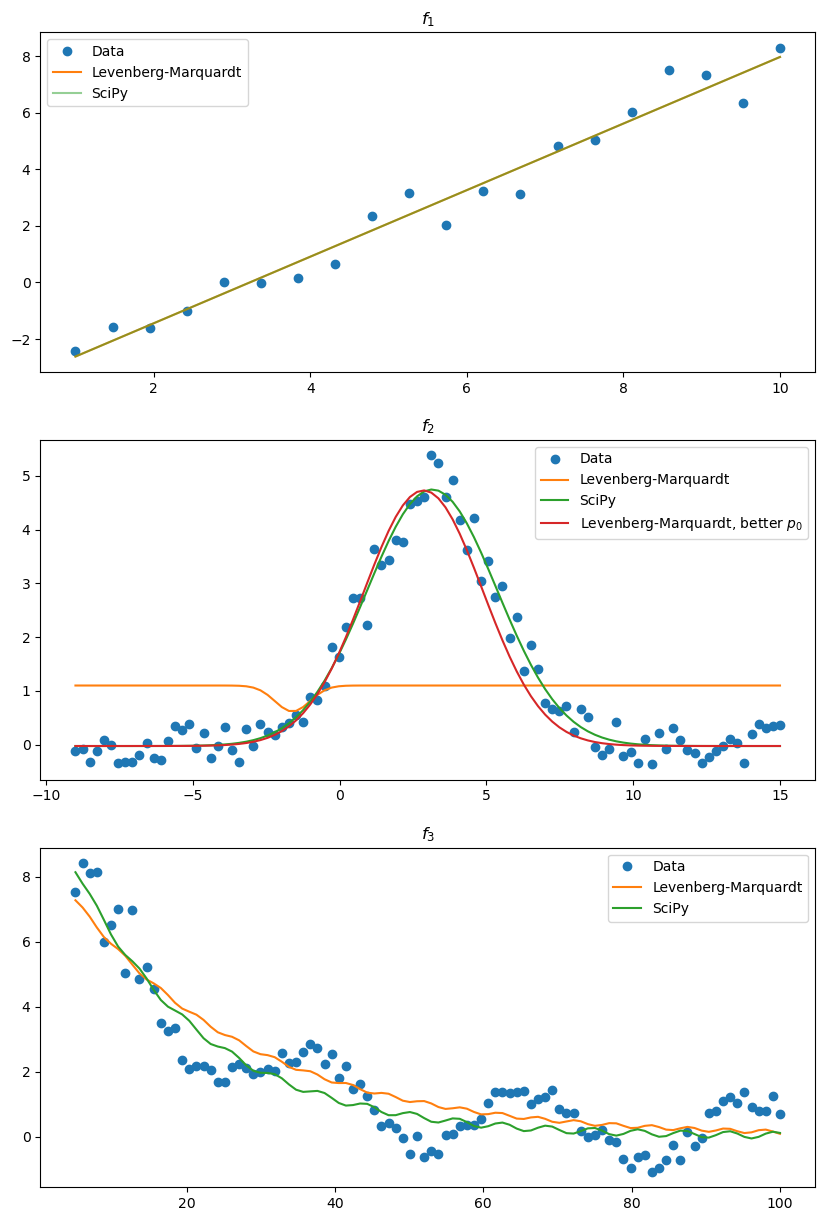

In [71]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(t1, y1, ls="None", marker="o", label="Data")
axs[0].plot(t1, f1(t1, *p1), label="Levenberg-Marquardt")
axs[0].plot(t1, f1(t1, *sciP1), label="SciPy", alpha=0.5)
axs[0].set_title(f"$f_1$")
axs[0].legend()
axs[1].plot(t2, y2, ls="None", marker="o", label="Data")
axs[1].plot(t2, f2(t2, *p2), label="Levenberg-Marquardt")
axs[1].plot(t2, f2(t2, *sciP2), label="SciPy")
axs[1].plot(t2, f2(t2, *p22), label="Levenberg-Marquardt, better $p_0$")
axs[1].set_title(f"$f_2$")
axs[1].legend()
axs[2].plot(t3, y3, ls="None", marker="o", label="Data")
axs[2].plot(t3, f3(t3, *p3), label="Levenberg-Marquardt")
axs[2].plot(t3, f3(t3, *sciP3), label="SciPy")
axs[2].set_title(f"$f_3$")
axs[2].legend()

array([ 4.77204307,  3.15252552,  3.13554821, -0.02478796])